# Foundations-2025 — Probability & Bayes (concepts + examples)

**Purpose:** A compact, Kaggle-ready notebook introducing core probability concepts and Bayesian reasoning with runnable NumPy/SciPy examples. It includes conditional probability, Bayes' theorem (disease testing), Beta-Bernoulli conjugacy, Bayesian update visualizations, Normal-Normal conjugacy (Gaussian likelihood with known variance), MAP estimation, and a small demonstration of Bayesian linear regression posterior (closed-form).

**Usage:** Run sequentially in a Kaggle kernel. The notebook uses NumPy, SciPy, Matplotlib, and scikit-learn (all available on Kaggle by default).


In [1]:
# Environment check (optional)
import sys, platform, numpy as np, scipy, matplotlib
import sklearn
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'SciPy:', scipy.__version__, 'matplotlib:', matplotlib.__version__, 'scikit-learn:', sklearn.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 SciPy: 1.15.3 matplotlib: 3.7.2 scikit-learn: 1.2.2


## Imports & helper utilities
Minimal imports and helper functions for plotting and numeric stability.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, bernoulli, norm
np.random.seed(0)

def plot_beta_prior_posterior(a0, b0, k, n, ax=None):
    # a0,b0 prior; k successes in n trials
    a_post = a0 + k
    b_post = b0 + n - k
    xs = np.linspace(0,1,400)
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.plot(xs, beta.pdf(xs, a0, b0), label=f'prior Beta({a0},{b0})')
    ax.plot(xs, beta.pdf(xs, a_post, b_post), label=f'posterior Beta({a_post},{b_post})')
    ax.axvline(k/n, color='k', linestyle='--', label='MLE')
    ax.set_xlabel('p'); ax.set_ylabel('density'); ax.legend()
    return ax



## 1) Quick refresher: probability basics
- **Probability mass / density**: discrete vs continuous.  
- **Conditional probability:** P(A|B) = P(A∩B)/P(B).  
- **Independence:** P(A∩B)=P(A)P(B).  

We start with a tiny discrete example to illustrate conditional probability.

In [3]:
from collections import Counter

# Discrete joint example: two coins (A, B), outcomes = ('H','H'), ('H','T'), ...
outcomes = [(a,b) for a in ['H','T'] for b in ['H','T']]
prob = {o: 1/4 for o in outcomes}  # fair independent coins
# Example: P(A=H | B=H)
num = sum(p for (a,b),p in prob.items() if a=='H' and b=='H')
den = sum(p for (a,b),p in prob.items() if b=='H')
print('P(A=H | B=H) =', num/den)
print('Independence check: P(A=H) =', sum(p for (a,b),p in prob.items() if a=='H'))


P(A=H | B=H) = 0.5
Independence check: P(A=H) = 0.5


## 2) Bayes' theorem — intuitive example (disease testing)
Bayes theorem:

\[P(Disease|Test+) = \frac{P(Test+|Disease)P(Disease)}{P(Test+)}\]

We demonstrate why low prevalence (prior) can make positive tests mostly false positives (counter-intuitive).

P(disease | test+): 0.32423208191126257


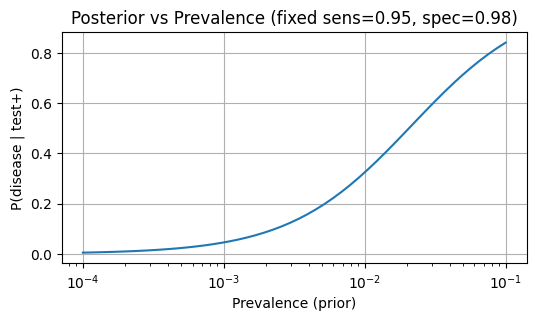

In [4]:
def bayes_disease(prior, sens, spec):
    # prior = P(D), sens = P(+|D), spec = P(-|~D)
    p_pos = sens * prior + (1-spec) * (1-prior)
    posterior = (sens * prior) / p_pos
    return posterior

# example parameters
prior = 0.01
sens = 0.95
spec = 0.98
print('P(disease | test+):', bayes_disease(prior, sens, spec))

# Visualize posterior vs prior for varying prevalence
ps = np.logspace(-4, -1, 50)
post = [bayes_disease(p, sens, spec) for p in ps]
plt.figure(figsize=(6,3))
plt.semilogx(ps, post)
plt.xlabel('Prevalence (prior)'); plt.ylabel('P(disease | test+)'); plt.grid(True)
plt.title('Posterior vs Prevalence (fixed sens=0.95, spec=0.98)')
plt.show()


## 3) Beta-Bernoulli conjugacy — coin flips & updating beliefs
Beta(a,b) prior with Bernoulli likelihood (coin flips) gives Beta posterior. We'll simulate coin flips and visualize prior→posterior updates.

True p=0.6, observed successes k=19/40


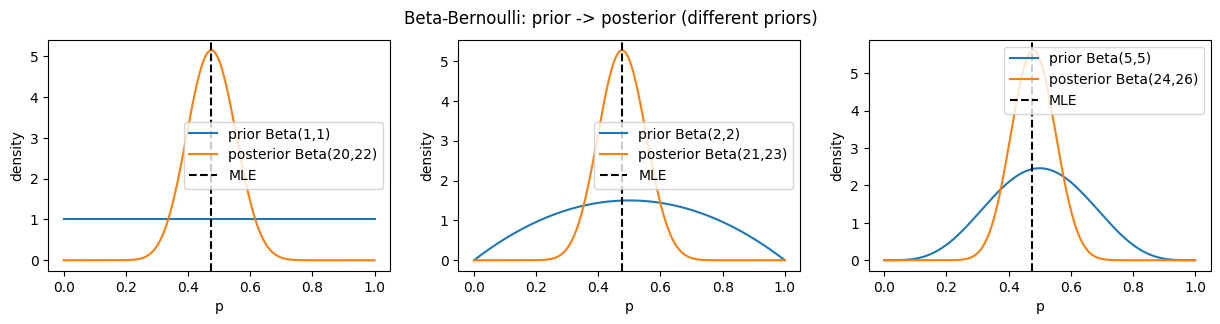

In [5]:
# Simulate coin flips and update
true_p = 0.6
N = 40
data = bernoulli.rvs(true_p, size=N)
k = data.sum()
print(f'True p={true_p}, observed successes k={k}/{N}')

# Prior choices
priors = [(1,1),(2,2),(5,5)]
fig, axes = plt.subplots(1,3, figsize=(15,3))
for (a0,b0), ax in zip(priors, axes):
    plot_beta_prior_posterior(a0, b0, k, N, ax=ax)
plt.suptitle('Beta-Bernoulli: prior -> posterior (different priors)')
plt.show()


### Posterior predictive
We can compute the posterior predictive probability of the next flip being heads: it's (a_post)/(a_post + b_post).

In [6]:
a0, b0 = 2, 2
a_post = a0 + k
b_post = b0 + N - k
ppred = a_post / (a_post + b_post)
print('Posterior predictive P(next=1):', ppred)


Posterior predictive P(next=1): 0.4772727272727273


## 4) Normal-Normal conjugacy (known variance)
If the likelihood is Gaussian with known variance and we place a Gaussian prior on the mean, the posterior is Gaussian with closed-form update. We'll show math and a small example.

Posterior mean: 4.18633295971825
Posterior std: 0.4428074427700477


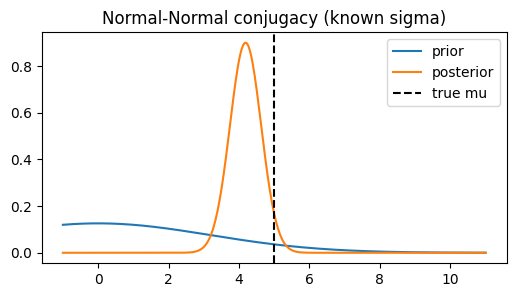

In [7]:
def normal_normal_update(mu0, sigma0_sq, data, sigma_sq):
    # mu0 prior mean, sigma0_sq prior variance, data: 1D array, sigma_sq likelihood variance
    n = len(data)
    xbar = np.mean(data)
    post_var = 1 / (n / sigma_sq + 1 / sigma0_sq)
    post_mean = post_var * (n * xbar / sigma_sq + mu0 / sigma0_sq)
    return post_mean, post_var

# Simulate data from N(5, 2^2)
true_mu = 5.0
sigma = 2.0
data = np.random.randn(20) * sigma + true_mu
mu0, sigma0_sq = 0.0, 10.0
post_mean, post_var = normal_normal_update(mu0, sigma0_sq, data, sigma**2)
print('Posterior mean:', post_mean)
print('Posterior std:', np.sqrt(post_var))

# Visualize prior and posterior
xs = np.linspace(true_mu-6, true_mu+6, 400)
prior_pdf = norm.pdf(xs, loc=mu0, scale=np.sqrt(sigma0_sq))
post_pdf = norm.pdf(xs, loc=post_mean, scale=np.sqrt(post_var))
plt.figure(figsize=(6,3))
plt.plot(xs, prior_pdf, label='prior')
plt.plot(xs, post_pdf, label='posterior')
plt.axvline(true_mu, color='k', linestyle='--', label='true mu')
plt.legend(); plt.title('Normal-Normal conjugacy (known sigma)'); plt.show()


## 5) MAP estimation vs full Bayesian
Discuss difference: MAP gives point estimate (mode of posterior), full Bayesian keeps posterior uncertainty. For conjugate cases, MAP is easy: e.g., Normal-Normal MAP equals posterior mean (same here since Gaussian). For Beta-Bernoulli, MAP is (a_post-1)/(a_post+b_post-2) when a_post,b_post>1.

In [8]:
# Example: MAP for Beta posterior
map_est = (a_post - 1) / (a_post + b_post - 2) if (a_post>1 and b_post>1) else a_post/(a_post+b_post)
print('MAP estimate for p (Beta posterior):', map_est)
print('Posterior mean:', a_post/(a_post+b_post))


MAP estimate for p (Beta posterior): 0.47619047619047616
Posterior mean: 0.4772727272727273


## 6) Bayesian Linear Regression (closed-form posterior)
We present a concise closed-form Bayesian linear regression with Gaussian prior on weights and Gaussian likelihood (known variance). The posterior is Gaussian with mean and covariance given analytically.

In [9]:
def bayesian_linear_regression_posterior(X, y, alpha, sigma_sq):
    # Prior: w ~ N(0, alpha^{-1} I)
    # Likelihood: y|X,w ~ N(Xw, sigma_sq I)
    # Returns posterior mean and covariance
    n, d = X.shape
    A = alpha * np.eye(d) + (1.0 / sigma_sq) * (X.T @ X)
    cov = np.linalg.inv(A)
    mean = (1.0 / sigma_sq) * cov @ X.T @ y
    return mean, cov

# Synthetic example
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=200, n_features=5, noise=5.0, random_state=0)
X = np.hstack([np.ones((X.shape[0],1)), X])  # add bias
alpha = 1.0  # prior precision
sigma_sq = 25.0  # likelihood variance
w_mean, w_cov = bayesian_linear_regression_posterior(X, y, alpha, sigma_sq)
print('Posterior mean shape:', w_mean.shape)
print('Posterior covariance shape:', w_cov.shape)

# Predictive distribution for new X_new
X_new = X[:5]
pred_mean = X_new @ w_mean
pred_var = np.sum(X_new @ w_cov * X_new, axis=1) + sigma_sq  # diag(X_new cov X_new^T) + sigma^2
print('Predictive mean (first 5):', pred_mean)
print('Predictive std (first 5):', np.sqrt(pred_var))


Posterior mean shape: (6,)
Posterior covariance shape: (6, 6)
Predictive mean (first 5): [-60.46926556 -43.88818808 -92.82472861 136.22738367  66.69412282]
Predictive std (first 5): [5.06518321 5.05625333 5.03102885 5.0829462  5.05888273]


## 7) Practical notes & when to use Bayesian methods
- Bayesian methods provide calibrated uncertainty which is useful in decision-making.  
- Conjugacy gives closed-form updates; otherwise use MCMC or variational inference.  
- Priors encode domain knowledge — choose informative priors when data is scarce.  

**Extensions you can add:** hierarchical models, MCMC sampling (PyMC3/NumPyro), variational inference, Bayesian neural networks (e.g., via Bayes by Backprop).


## Checklist before adding to portfolio
1. Add a short README summarizing the experiments and takeaways.  
2. Include seeds, parameter choices, and small write-up interpreting results.  
3. Optionally save the key plots as PNGs and include them in your portfolio.
